In [1]:
import numpy as np
import pennylane as qml 
import torch

def create_circuit(n_qubits,n_layers=None,circ = "simplified_two_design",fim=False, shots=None):

    dev = qml.device("default.qubit.torch", wires=n_qubits, shots=shots)

    def RZRY(params):
        #qml.SpecialUnitary(params, wires=range(n_qubits))
        #qml.SimplifiedTwoDesign(initial_layer_weights=init_params, weights=params, wires=range(n_qubits))
        #qml.AngleEmbedding(params,wires=range(n_qubits))
        for q in range(n_qubits):
            qml.Hadamard(wires=q)

        for w in range(n_layers): 
            for q in range(n_qubits):
                index = w * (2*n_qubits) + q * 2
                qml.RZ(params[index],wires=q)
                qml.RY(params[index + 1],wires=q)
        
        qml.broadcast(qml.CNOT , wires=range(n_qubits), pattern="all_to_all")
        
        return qml.probs(wires=range(n_qubits))

    def S2D(init_params,params,measurement_qubits=0,prod_approx=False):
        #qml.SpecialUnitary(params, wires=range(n_qubits))
        qml.SimplifiedTwoDesign(initial_layer_weights=init_params, weights=params, wires=range(n_qubits))
        
        #qml.broadcast(qml.CNOT , wires=range(n_qubits), pattern="all_to_all")
        if not prod_approx:
            return qml.probs(wires=list(range(measurement_qubits)))
        else:
            return [qml.probs(i) for i in range(measurement_qubits)]

    def SU(params):
        qml.SpecialUnitary(params, wires=range(n_qubits))
        
        ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
        for i in range(2,n_qubits):
            ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))

        return qml.expval(ZZ)
    
    def simmpleRZRY(params,cnots=True):
        qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        qml.broadcast(qml.RZ, wires=range(n_qubits), pattern="single", parameters=params[0])
        qml.broadcast(qml.RY, wires=range(n_qubits), pattern="single", parameters=params[1])
        if cnots:
            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

            return qml.expval(qml.PauliZ(n_qubits-1))
        else:
            ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
            for i in range(2,n_qubits):
                ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))

            return qml.expval(ZZ)
        
    def RY(params,y=True,probs=False,prod=False, entanglement=None):
        #qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        qml.broadcast(qml.RY, wires=range(n_qubits), pattern="single", parameters=params)
        #qml.broadcast(qml.CZ, wires=range(n_qubits), pattern="all_to_all")

        if entanglement=="all_to_all":
            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="all_to_all")
        
        if y==True:
            #YY = qml.operation.Tensor(qml.PauliY(0), qml.PauliY(1))
            YY = [qml.PauliZ(0), qml.PauliZ(1)]
            for i in range(2,n_qubits):
                #YY = qml.operation.Tensor(YY, qml.PauliY(i))
                YY.append(qml.PauliZ(i))
            
            #return [qml.expval(i) for i in YY]
            return qml.expval(YY)

        elif probs==False:

            ZZ = qml.operation.Tensor(qml.PauliZ(0), qml.PauliZ(1))
            #ZZ = [qml.PauliZ(0), qml.PauliZ(1)]
            for i in range(2,n_qubits):
                ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))        
                #ZZ.append(qml.PauliZ(i))        

            #return [qml.expval(i) for i in ZZ]
            return qml.expval(ZZ)

        else:
            if prod:
                return [qml.probs(i) for i in range(n_qubits)]
            else:
                return qml.probs(wires=range(n_qubits))
            
        
        
    def GHZ(params,measurement_qubits=0):
        qml.RY(params,wires=0)
        qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

        return qml.probs(wires=range(measurement_qubits))

    def random_product_state(params,gate_sequence=None):
                
        for i in range(n_qubits):
            qml.RY(np.pi / 4, wires=i)

        for ll in range(len(params)):

            for i in range(n_qubits):
                gate_sequence["{}{}".format(ll,i)](params[ll][i], wires=i)

            #for i in range(n_qubits - 1):
                #qml.CZ(wires=[i, i + 1])
    def SEL(params, measurement_qubits=0):
        qml.StronglyEntanglingLayers(params, wires=range(n_qubits))
        return qml.probs(wires=range(measurement_qubits))
    
    def RL(params, measurement_qubits=0):
        qml.RandomLayers(params, ratio_imprim=0.8 ,imprimitive=qml.CZ, wires=range(n_qubits))
        return qml.probs(wires=range(measurement_qubits))
    
    if circ == "rzry":
        qcircuit = RZRY
    elif circ == "simplified_two_design":
        qcircuit = S2D
    elif circ == "special_unitary":
        qcircuit = SU
    elif circ == "simpleRZRY":
        qcircuit = simmpleRZRY
    elif circ == "RY":
        qcircuit = RY
    elif circ == "ghz":
        qcircuit = GHZ
    elif circ == "random_product_state":
        qcircuit = random_product_state
    elif circ == "SEL":
        qcircuit = SEL
    elif circ == "RL":
        qcircuit = RL
    if not fim:
        circuit = qml.QNode(qcircuit, dev,interface="torch", diff_method="backprop")
    else:
        circuit = qml.QNode(qcircuit, dev)

    return circuit

def compute_gradient(log_prob, w):
    """Compute gradient of the log probability with respect to weights.
    
    Args:
    - log_prob (torch.Tensor): The log probability tensor.
    - w (torch.Tensor): The weights tensor, with requires_grad=True.

    Returns:
    - numpy.ndarray: The gradient of log_prob with respect to w, flattened.
    """
    if w.grad is not None:
        w.grad.zero_()
    log_prob.backward(retain_graph=True)
    
    if w.grad is None:
        raise ValueError("The gradient for the given log_prob with respect to w is None.")
    
    return w.grad.view(-1).detach().numpy()

def policy(probs, policy_type="contiguous-like", n_actions=2, n_qubits=1):

    if policy_type == "contiguous-like":
        return probs
    elif policy_type == "parity-like":
        policy = torch.zeros(n_actions)
        for i in range(len(probs)):
            a=[]
            for m in range(int(np.log2(n_actions))):
                if m==0:    
                    bitstring = np.binary_repr(i,width=n_qubits)
                else:
                    bitstring = np.binary_repr(i,width=n_qubits)[:-m]
                
                a.append(bitstring.count("1") % 2)
            policy[int("".join(str(x) for x in a),2)] += probs[i]

        return policy    
    
def compute_policy_and_gradient(args):
    n_qubits, shapes, type , n_actions, policy_type, clamp = args

    if policy_type == "parity-like":
        measure_qubits = n_qubits
    else:
        measure_qubits = int(np.log2(n_actions))

    qc = create_circuit(n_qubits, circ=type, fim=False, shots=None)

    if type == "simplified_two_design":
        weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]    
        weights_tensor_init = torch.tensor(weights[0], requires_grad=False)
        weights_tensor_params = torch.tensor(weights[1], requires_grad=True)
        
        probs = qc(weights_tensor_init,weights_tensor_params, measurement_qubits=measure_qubits)

    else:
        weights = [np.random.uniform(-np.pi,np.pi,size=shape) for shape in shapes]    
        weights_tensor_params = torch.tensor(weights, requires_grad=True)

        probs = qc(weights_tensor_params, measurement_qubits=measure_qubits)

    pi = policy(probs, policy_type=policy_type, n_actions=n_actions, n_qubits=n_qubits)
    if clamp is not None:
        pi = torch.clamp(pi, clamp, 1)

    dist = torch.distributions.Categorical(probs=pi)
    
    action = dist.sample()
    log_prob = dist.log_prob(action)

    gradient_no_clamp = np.linalg.norm(compute_gradient(log_prob, weights_tensor_params), 2)
    return gradient_no_clamp


In [3]:
import pennylane as qml
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
from collections import deque

In [4]:
#utils

def create_zz_operator(n_qubits):
    ZZ = qml.PauliZ(0)
    for i in range(1, n_qubits):
        ZZ = qml.operation.Tensor(ZZ, qml.PauliZ(i))
    return ZZ

def measure_selection(measure_type, observables, measure_qubits):
    if measure_type == 'probs':
        if observables is None:
            return qml.probs(wires=range(measure_qubits))
        else:
            return qml.probs(op=observables, wires=range(measure_qubits))
    elif measure_type == 'expval':
        op = observables if observables is not None else create_zz_operator(measure_qubits)
        return qml.expval(op=op) 
    
def create_optimizer_with_lr(params, lr_list):
    optimizer = torch.optim.Adam([
        {'params': params, 'lr': lr} for params, lr in zip(params, lr_list)
    ])
    return optimizer

def jerbi_circuit(n_qubits, n_layers, weight_init, input_init, measure_type, observables, measure_qubits):

    dev = qml.device("default.qubit", wires=n_qubits)

    observables = observables if observables is not None else None
    
    weight_shapes = {"params": (n_layers + 1, n_qubits, 2),
                     "input_params": (n_layers, n_qubits, 2)}
    
    init_method   = {"params": weight_init,
                     "input_params": input_init}

    @qml.qnode(dev, interface='torch', diff_method='parameter-shift')
    def qnode(inputs, params, input_params):

        qml.broadcast(qml.Hadamard, wires=range(n_qubits), pattern="single")
        
        for layer in range(n_layers):
            for wire in range(n_qubits):
                qml.RZ(params[layer][wire][0], wires=wire)
                qml.RY(params[layer][wire][1], wires=wire)

            qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="chain")

            for wire in range(n_qubits):
                qml.RY(input_params[layer][wire][0] * inputs[wire], wires=wire)
                qml.RZ(input_params[layer][wire][1] * inputs[wire], wires=wire)

        for wire in range(n_qubits):
            qml.RZ(params[-1][wire][0], wires=wire)
            qml.RY(params[-1][wire][1], wires=wire)
    
        return measure_selection(measure_type, observables, measure_qubits)

    model = qml.qnn.TorchLayer(qnode, weight_shapes=weight_shapes, init_method=init_method)

    return model

def S2D(n_qubits, n_layers, weight_init, input_init, measure_type, observables, measure_qubits):

    dev = qml.device("default.qubit", wires=n_qubits)

    observables = observables if observables is not None else None
    
    shapes = qml.SimplifiedTwoDesign.shape(n_layers=n_layers, n_wires=n_qubits)

    weight_shapes = {"params": shapes[1],
                     "input_params": shapes[0]}
    
    init_method   = {"params": weight_init,
                     "input_params": input_init}

    @qml.qnode(dev, interface='torch', diff_method='parameter-shift')
    def qnode(inputs, params, input_params):

        return measure_selection(measure_type, observables, measure_qubits)

    model = qml.qnn.TorchLayer(qnode, weight_shapes=weight_shapes, init_method=init_method)

    return model

In [5]:
class CircuitGenerator(nn.Module):

    def __init__(self, n_qubits, n_layers,  shots, design='jerbi_circuit', weight_init=torch.nn.init.uniform_, input_init = torch.nn.init.ones_, measure_type = 'probs', observables = None, measure_qubits = None):
        super(CircuitGenerator, self).__init__()
        self.n_qubits = n_qubits                        #number of qubits
        self.n_layers = n_layers                        #number of layers
        self.shots = shots                              #number of shots
        self.design = design                            #the circuit design
        self.measure_type = measure_type                #measure type - 'probs' or 'expval'
        self.observables = observables                  #observables if the user wants
        self.weight_init = weight_init                  #weight initialization method
        self.input_init = input_init                    #input weight initialization method
        if measure_qubits is None:
            self.measure_qubits = n_qubits

        if self.design == 'jerbi_circuit':
            self.circuit = jerbi_circuit(n_qubits=self.n_qubits,
                                        n_layers=self.n_layers,
                                        weight_init = self.weight_init,
                                        input_init = self.input_init,
                                        measure_type=self.measure_type,
                                        observables=self.observables,
                                        measure_qubits=self.measure_qubits)
        else:
            raise ValueError("Unsupported circuit type")

    def input(self,inputs):
            
        outputs = self.circuit(inputs)

        return outputs

    def get_params(self):

        params = list(self.circuit.parameters())

        for param in params:
            print(param)
    

In [6]:
class PolicyType(nn.Module):
    
    def __init__(self, n_qubits, n_actions, post_processing = 'raw_contiguous'):
        self.n_actions = n_actions
        self.n_qubits = n_qubits
        self.post_processing = post_processing


    def input(self,probs):

        if self.post_processing == 'raw_contiguous':
            policy = self.raw_contiguous(probs)
        elif self.post_processing == 'raw_parity':
            policy = self.raw_parity(probs)
        elif self.post_processing == 'softmax':
            policy = self.softmax(probs)
        else:
            raise ValueError("Invalid post-processing method specified.")

        return policy


    def raw_contiguous(self,probs):

        probs_flatten = probs.flatten()
        chunk_size = len(probs_flatten) // self.n_actions
        remainder = len(probs_flatten) % self.n_actions

        policy = []

        for i in range(self.n_actions):
            start = i * chunk_size
            end = (i + 1) * chunk_size

            if i < remainder:
                end += 1

            # Update the original policy list instead of creating a new one
            policy.append(sum(probs_flatten[start:end]))

        policy_tensor = torch.stack(policy)

        return policy_tensor
    

    def raw_parity(self,probs):

        if self.n_actions % 2 != 0:
            return('For parity-like policy, n_actions must be an even number')
        
        probs_flatten = probs.flatten()
        policy = torch.zeros(self.n_actions)
        counter = 0
        for prob in probs_flatten:
            policy[counter] += prob
            counter += 1
            if counter == self.n_actions:
                counter = 0
        
        policy_tensor = torch.stack(policy)

        return policy_tensor
    

    def softmax(self, probs, beta=1):
        if len(probs) == self.n_actions:
            scaled_output = probs * beta
            softmax_output = F.softmax(scaled_output, dim=0)
            return softmax_output

        else:
            probs_flatten = probs.flatten()
            chunk_size = len(probs_flatten) // self.n_actions
            remainder = len(probs_flatten) % self.n_actions

            policy = [0] * self.n_actions

            for i in range(self.n_actions):
                start = i * chunk_size
                end = (i + 1) * chunk_size

                if i < remainder:
                    end += 1

                policy[i] = sum(probs_flatten[start:end])

            policy_tensor = torch.tensor(policy, dtype=torch.float32, requires_grad=True)

            scaled_output = policy_tensor / beta
            softmax_output = F.softmax(scaled_output, dim=0)
            return softmax_output.detach()


In [7]:
class QuantumPolicyModel(nn.Module):
    def __init__(self, circuit, policy):
        super(QuantumPolicyModel, self).__init__()
        self.circuit = circuit
        self.policy = policy
        self.gradient_list = []

    def forward(self, inputs):

        probs = self.circuit.input(inputs)
        probs_processed = self.policy.input(probs)
        return probs_processed
    
    def sample(self, inputs):

        policy = self.forward(inputs)
        dist = torch.distributions.Categorical(policy)
        action = dist.sample()
        return action.item(), dist.log_prob(action), policy
    
    def sample_argmax(self, inputs):

        policy = self.forward(inputs)
        max_prob_action = torch.argmax(policy).item()
        return max_prob_action, torch.log(policy[max_prob_action]), policy
    
    def get_params(self):
        
        for name, param in self.circuit.named_parameters():
            if param.grad is not None:
                print(f'Parameter: {name}\n {param}\nGradients: {param.grad}\nGradient Norm: {torch.norm(param.grad)}\n')
            else:
                print(f'Parameter: {name}\nValue: {param}\nGradient: None\n')

    def grads(self):

        for name, param in self.circuit.named_parameters():
            if param.grad is not None:
                self.gradient_list.append(torch.norm(param.grad))
            else:
                self.gradient_list.append(0)

In [8]:
#standardized returns
import time
def reinforce(policy, optimizer, env, n_episodes=1000, max_t=1000, gamma=1.0, print_every=1):
    scores_deque = deque(maxlen=10)
    scores = []
    average_scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            if t==0:
                state_tensor = torch.tensor(state[0]).float()
            else:
                state_tensor = torch.tensor(state).float()
            action, log_prob, _, = policy.sample(state_tensor)
            saved_log_probs.append(log_prob)
            state, reward, done, _, _ = env.step(action)
            rewards.append(reward)
            if done:
                break


    # Total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        '''
    #unstandardized returns
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        policy_loss = []
        for log_prob in saved_log_probs:
            policy_loss.append(-log_prob * R)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        policy_sum = torch.cat(policy_unsqueezed).sum()
        #print('Unstandardized returns policy_loss:' + str(policy_sum))
        '''

    #standardized returns
        R=0
        policy_loss = []
        returns = []
        for r in rewards[::-1]:
            R = r + gamma * R
            returns.insert(0,R)
        returns = torch.tensor(returns)
        returns = (returns - returns.mean()) / (returns.std() + 1)

        for log_prob, R in zip(saved_log_probs, returns):
            policy_loss.append(-log_prob * R)

        policy_unsqueezed = [torch.unsqueeze(loss, 0) for loss in policy_loss]
        policy_sum = torch.cat(policy_unsqueezed).sum()
        #print('Standardized returns policy_loss:' + str(policy_sum))

    # Backpropagation
        start_time = time.time()
        optimizer.zero_grad()
        policy_sum.backward()
        optimizer.step()
        end_time = time.time()
        runtime = end_time-start_time
        #policy.get_params()        #prints the parameters values and gradients
        policy.grads()              #stores the gradient values

        average_scores.append(np.mean(scores_deque))
        if e % print_every == 0:
            print('Episode {}\tLast reward: {:.2f}\tLast 10 Episodes average reward: {:.2f}\tRuntime: {:.2f}'.format(e, scores_deque[-1], np.mean(scores_deque),runtime))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 1, np.mean(scores_deque)))
            break
    return scores, policy.gradient_list, average_scores  

In [10]:
n_qubits = 4
n_layers = 5
shots = 1000
n_actions = 2
beta = 1
#weight_init = torch.nn.init.uniform_
#input_init = torch.nn.init.uniform_

# Objects initialization
circuit = CircuitGenerator(n_qubits, n_layers, shots)
policy_type = PolicyType(n_qubits, n_actions)
pqc = QuantumPolicyModel(circuit,policy_type)

# Optimizers initialization
lr_list= [0.01,0.1]
params= circuit.parameters()
optimizers= create_optimizer_with_lr(params,lr_list)

#for name, param in circuit.named_parameters():
#    print(f'Parameter: {name}, Shape: {param.shape}, Requires Grad: {param.requires_grad}')

env = gym.make('CartPole-v1')
scores, gradient_list, average_scores = reinforce(pqc,optimizers,env,n_episodes=100,gamma=0.95)

Episode 1	Last reward: 24.00	Last 10 Episodes average reward: 24.00	Runtime: 64.24
Episode 2	Last reward: 12.00	Last 10 Episodes average reward: 18.00	Runtime: 30.49
Episode 3	Last reward: 14.00	Last 10 Episodes average reward: 16.67	Runtime: 35.42
Episode 4	Last reward: 27.00	Last 10 Episodes average reward: 19.25	Runtime: 68.32
Episode 5	Last reward: 16.00	Last 10 Episodes average reward: 18.60	Runtime: 41.23
Episode 6	Last reward: 23.00	Last 10 Episodes average reward: 19.33	Runtime: 57.44
Episode 7	Last reward: 15.00	Last 10 Episodes average reward: 18.71	Runtime: 37.58
Episode 8	Last reward: 59.00	Last 10 Episodes average reward: 23.75	Runtime: 149.89
Episode 9	Last reward: 57.00	Last 10 Episodes average reward: 27.44	Runtime: 146.09
Episode 10	Last reward: 62.00	Last 10 Episodes average reward: 30.90	Runtime: 162.16
Episode 11	Last reward: 22.00	Last 10 Episodes average reward: 30.70	Runtime: 64.19
Episode 12	Last reward: 70.00	Last 10 Episodes average reward: 36.50	Runtime: 179.

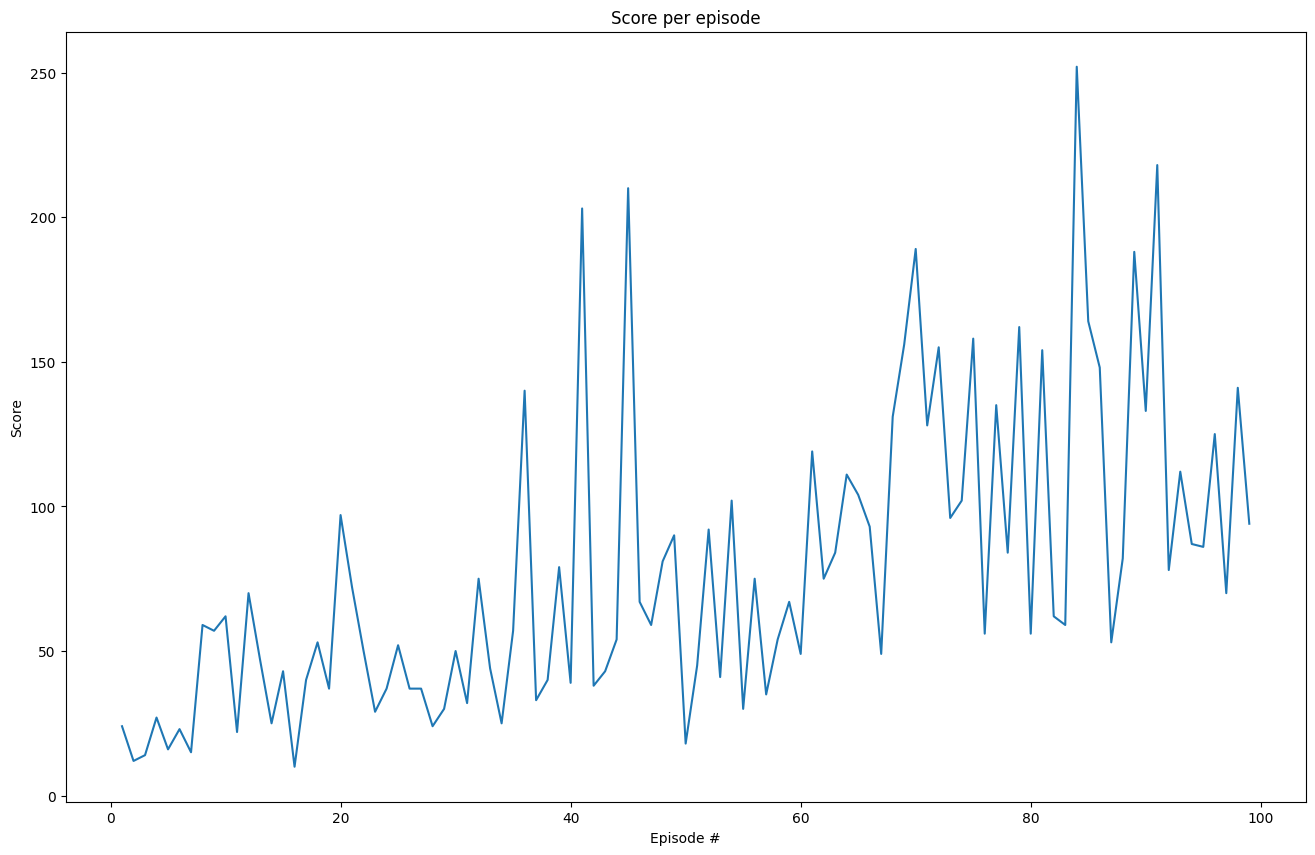

In [14]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)


fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.title('Score per episode')
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

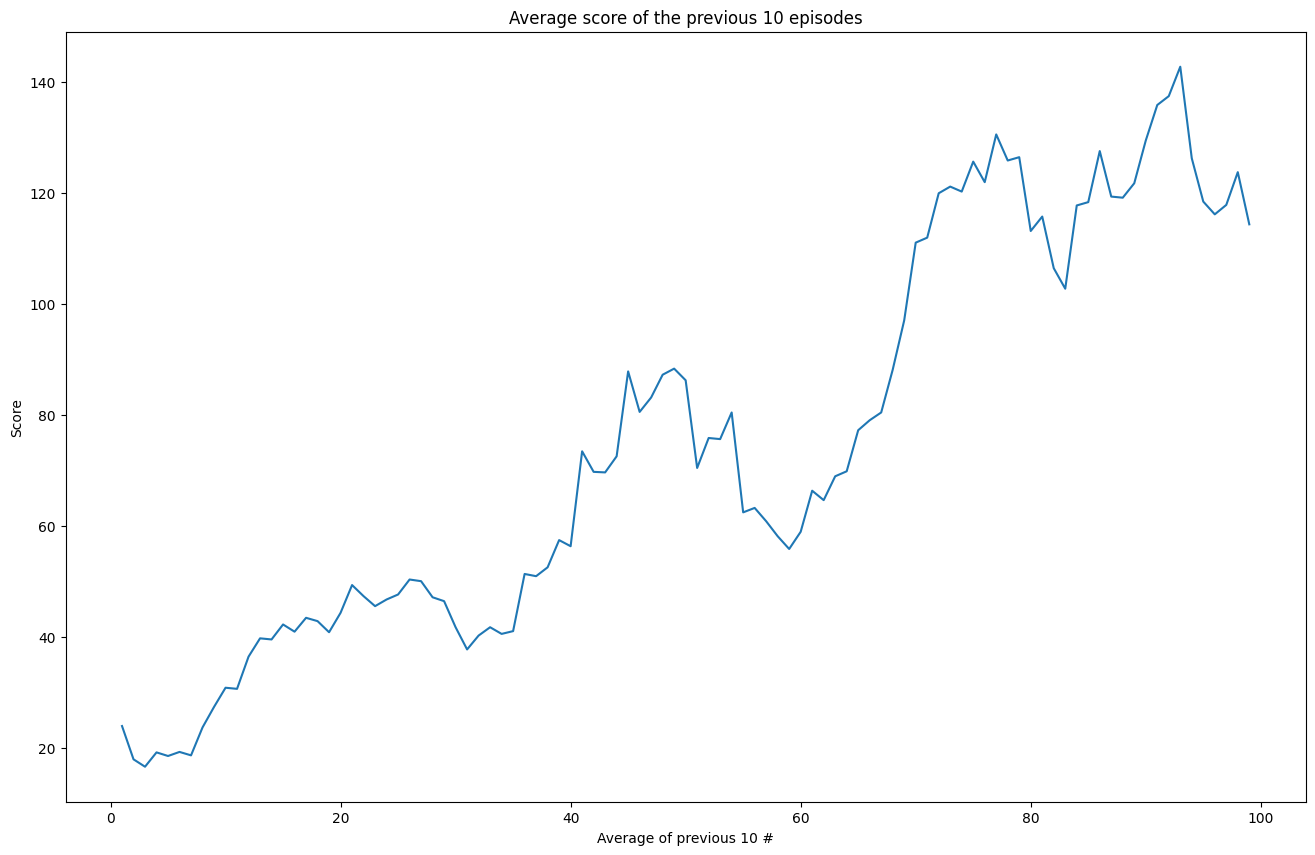

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(average_scores)+1), average_scores)
plt.ylabel('Score')
plt.title('Average score of the previous 10 episodes')
plt.xlabel('Average of previous 10 #')
plt.show()

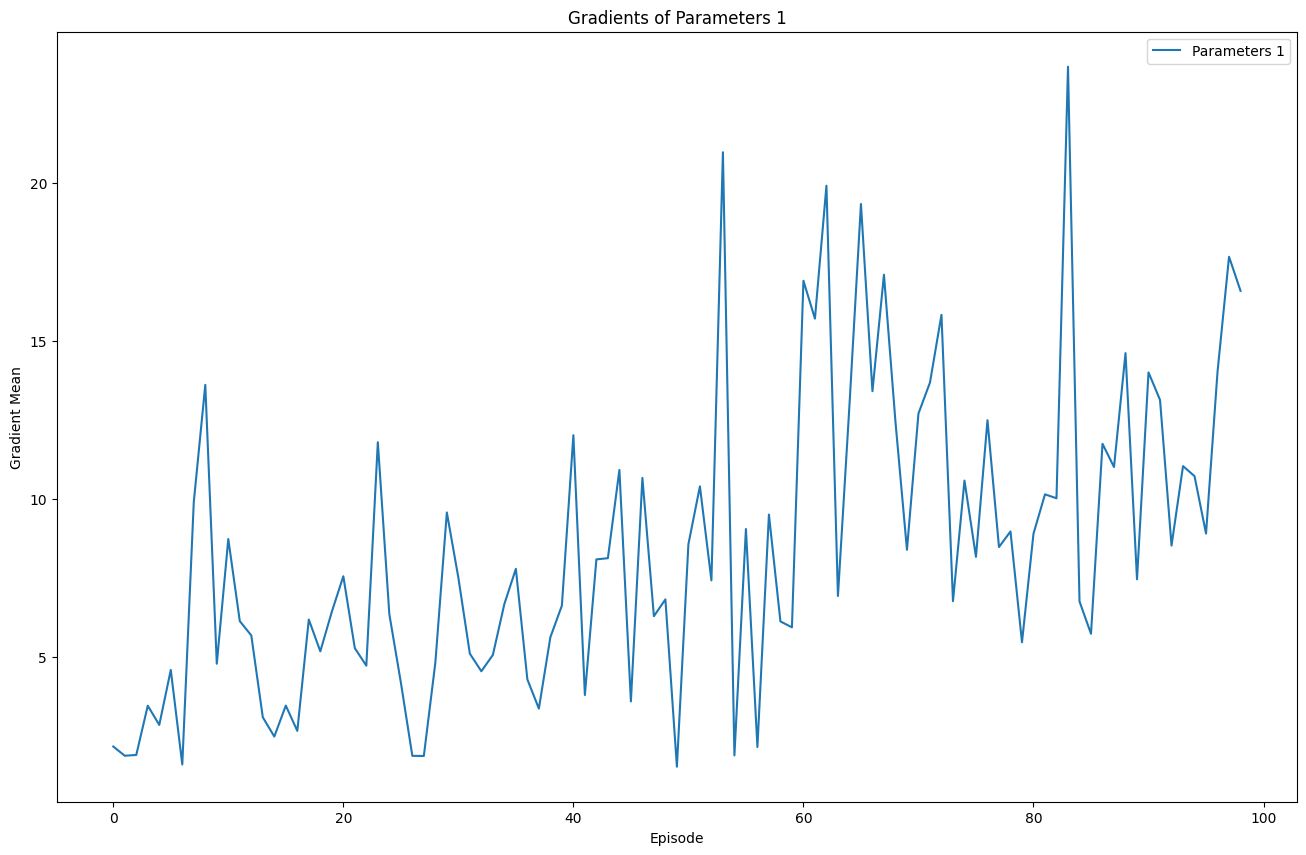

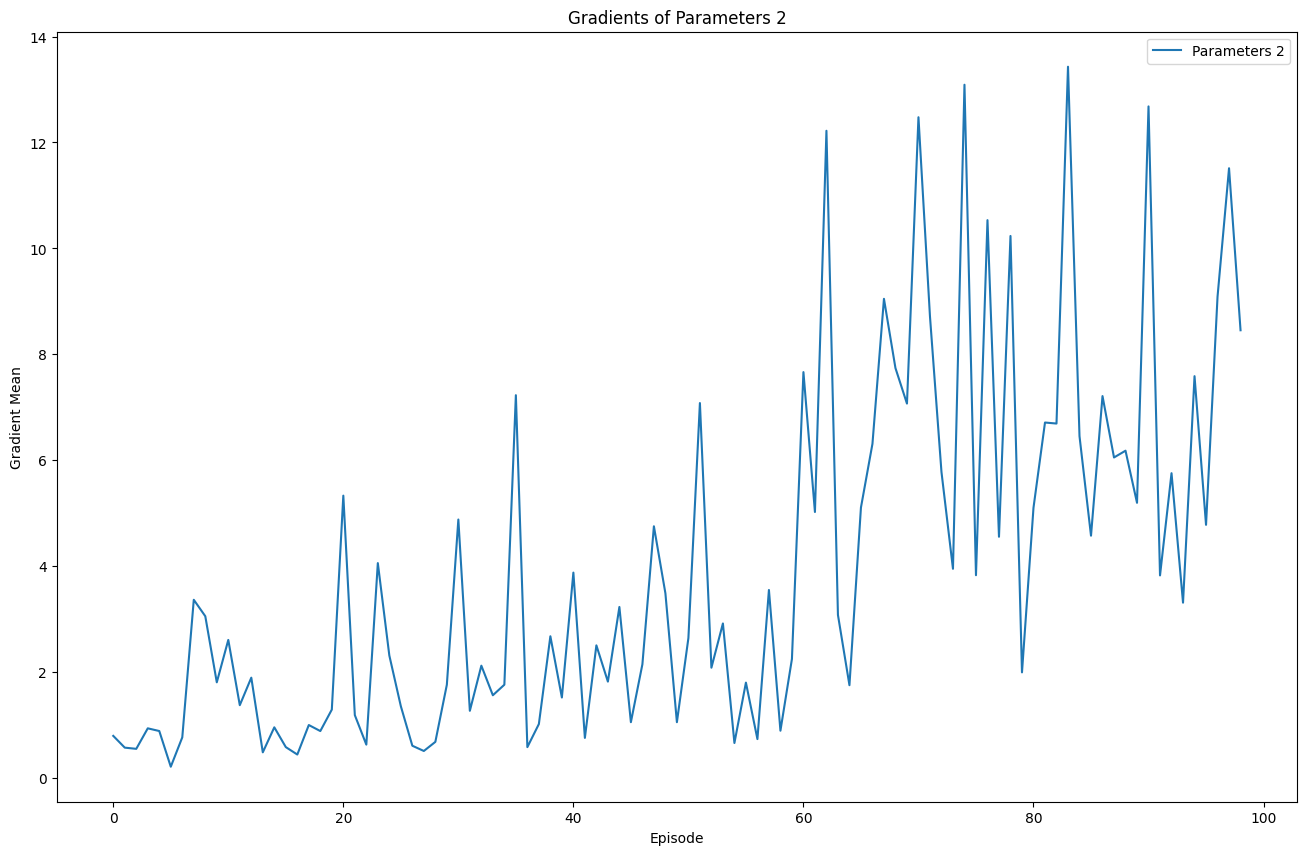

In [12]:
# Gradients for Parameters and Input Parameters

param1_gradients = gradient_list[::2]
param2_gradients = gradient_list[1::2]

# Plotting gradients for parameters 1
plt.plot(param1_gradients, label='Parameters')
plt.xlabel('Episode')
plt.ylabel('Gradient Mean')
plt.title('Gradients of Parameters')
plt.legend()
plt.show()

# Plotting gradients for parameters 2
plt.plot(param2_gradients, label='Parameters')
plt.xlabel('Episode')
plt.ylabel('Gradient Mean')
plt.title('Gradients of Input Parameters')
plt.legend()
plt.show()